In [ ]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [1]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio

Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [2]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [4]:
#dc.list_measurements()

In [5]:
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [6]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range


vec_fname = '/g/data/r78/lxl554/hovmoller/Fish River Fire Project.shp' #comment these lines out if running without polygon
src = fiona.open(vec_fname)
geom = shape(src[0]['geometry'])




#Define temporal range
start_of_epoch = '2000-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-07-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     #'red', 
                     'nir',
                     #'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

#query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -13.98
lat_min = -14.05
lon_max = 131.10
lon_min = 130.95
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [7]:
print query

{'y': (-13.98, -14.05), 'x': (130.95, 131.1), 'crs': 'EPSG:4326', 'time': ('2000-01-01', '2016-07-31')}


## Retrieve surface reflectance data


In [8]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [9]:
#need to put in NBR

In [10]:
#load sensor specific band adjustment tuples for TSS and brightness

In [11]:
#load sensor specific band adjustment tuples for TSS 
ls5_tss_constant = 3983
ls5_tss_exponent = 1.6246
ls7_tss_constant = 3983
ls7_tss_exponent = 1.6246
ls8_tss_constant = 3957
ls8_tss_exponent = 1.6436

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [12]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [13]:
sensor1_nbar
affine = sensor1_nbar.affine

In [14]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [15]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, ga_good_pixel= True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [16]:
#Fix the TSS coefficients for each sensor
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR','NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor1_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor1_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor1_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    #sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    #sensor1_rsindex['NDWI'] = ((sensor1_nbar['swir1']-sensor1_nbar['green'])/(sensor1_nbar['swir1']+sensor1_nbar['green']))
    sensor1_rsindex['NBR'] = ((sensor1_nbar['nir']-sensor1_nbar['swir2'])/(sensor1_nbar['nir']+sensor1_nbar['swir2']))
    #Need this to reference into a tuple - Check with Damien    
    #sensor1_rsindex['TSS'] = (ls8_tss_constant*((sensor1_nbar['green']+sensor1_nbar['red'])/20000)**ls8_tss_exponent)

In [17]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [18]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [19]:
s2_cloud_free = masking.make_mask(sensor2_pq, ga_good_pixel= True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [20]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor2_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    #sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))
    #sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    sensor2_rsindex['NBR'] = ((sensor2_nbar['nir']-sensor2_nbar['swir2'])/(sensor2_nbar['nir']+sensor2_nbar['swir2']))
    #sensor2_rsindex['TSS'] = (ls7_tss_constant*((sensor2_nbar['green']+sensor2_nbar['red'])/20000)**ls7_tss_exponent)


In [21]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [22]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [23]:
s3_cloud_free = masking.make_mask(sensor3_pq, ga_good_pixel= True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

In [24]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor3_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    #sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))
    #sensor3_rsindex['NDWI'] = ((sensor3_nbar['swir1']-sensor3_nbar['green'])/(sensor3_nbar['swir1']+sensor3_nbar['green']))
    sensor3_rsindex['NBR'] = ((sensor3_nbar['nir']-sensor3_nbar['swir2'])/(sensor3_nbar['nir']+sensor3_nbar['swir2']))
    #sensor3_rsindex['TSS'] = ((sensor3_nbar['green']+sensor3_nbar['red'])/2)
    #sensor3_rsindex['TSS'] = (ls5_tss_constant*((sensor3_nbar['green']+sensor3_nbar['red'])/20000)**ls5_tss_exponent)


## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [25]:
#Concatenate and sort the different sensor xarrays into a single xarray

nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['affine'] = affine


'''
all_tss_sorted = xr.concat([sensor1_rsindex['TSS'], sensor2_rsindex['TSS'], sensor3_rsindex['TSS']], dim='time')
time_sorted = all_tss_sorted.time.argsort()
all_tss_sorted = all_tss_sorted.isel(time=time_sorted)'''

"""all_ndvi_sorted = xr.concat([sensor1_rsindex['NDVI'], sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi_sorted.time.argsort()
all_ndvi_sorted = all_ndvi_sorted.isel(time=time_sorted)
"""
all_nbr_sorted = xr.concat([sensor1_rsindex['NBR'], sensor2_rsindex['NBR'], sensor3_rsindex['NBR']], dim='time')
time_sorted = all_nbr_sorted.time.argsort()
all_nbr_sorted = all_nbr_sorted.isel(time=time_sorted)
all_nbr_sorted.attrs['affine'] = affine




In [26]:
#clean up per sensor xarrays to free up some memory
#del sensor1_nbar
del sensor2_nbar
del sensor3_nbar
del sensor1_rsindex
del sensor2_rsindex
del sensor3_rsindex

In [27]:
#geom_w = warp_geometry(geom, query['crs'], sensor1_nbar.crs.wkt)
#trans = transect(sensor1_nbar, geom_w, 25)


In [28]:
sensor1_nbar.crs.wkt

AttributeError: 'Dataset' object has no attribute 'crs'

In [29]:
trans.red.plot(x='distance', y='time')

NameError: name 'trans' is not defined

The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

## Plotting a multi-band image

In [30]:
print 'The number of time slices at this location is' 
print all_nbr_sorted.shape[0]

The number of time slices at this location is
808


In [210]:
#select time slice of interest
time_slice = 287
rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir2', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 3500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

#imshow(scaled, interpolation = 'nearest')

<IPython.core.display.Javascript object>


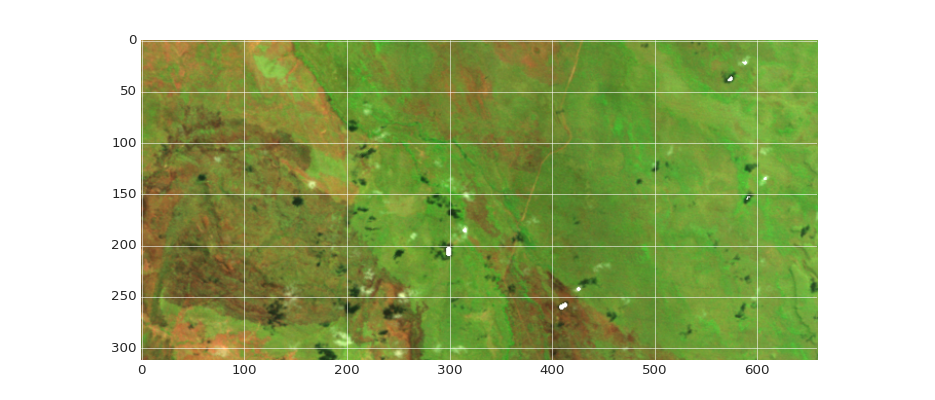

In [211]:
#Click on this image to chose the location for the Hovmoller extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(scaled)
#plt.scatter(x=[x], y=[y], c='r')

plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

In [203]:
x, y
timeactual = all_nbr_sorted.time[time_slice]
print timeactual

<xarray.DataArray 'time' ()>
numpy.datetime64('2007-08-25T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2007-08-25
Attributes:
    units: seconds since 1970-01-01 00:00:00


<IPython.core.display.Javascript object>


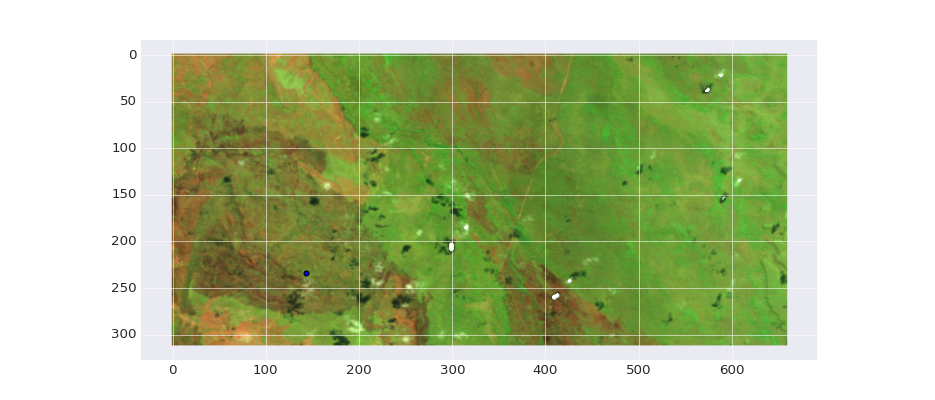

In [212]:
#Click on this image to chose the location for the Hovmoller extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x2, y2
    x2, y2 = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x2,y2)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(scaled)
#plt.scatter(x=[x], y=[y], c='r')
plt.scatter(x=[x2], y=[y2], c='b')

plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)
timeactual = all_nbr_sorted.time[time_slice]

plt.show()
display(w)
savefig('/home/554/lxl554/Desktop/NBR graphics/fishriver_2007_08.png')

<IPython.core.display.Javascript object>


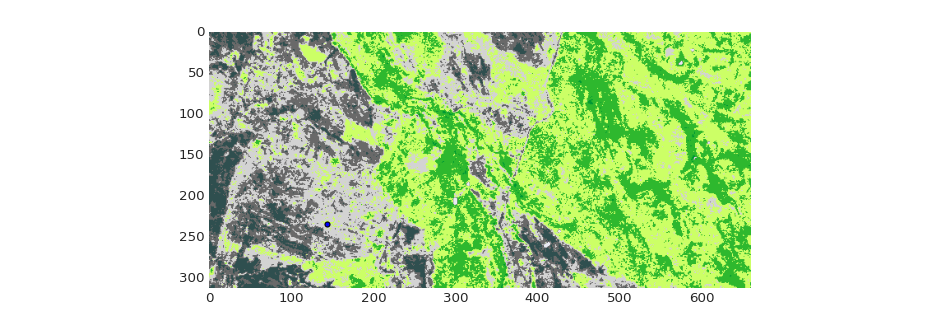

<xarray.DataArray 'time' ()>
numpy.datetime64('2007-08-02T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2007-08-02


In [213]:
fig = plt.figure(figsize=(11.69,4))

#Define coordinates of interest
timeactual = all_nbr_sorted.time[time_slice]

tss_min = 0
tss_max = 2000
#plt.scatter(x=[x], y=[y], c='r')
plt.scatter(x=[x2], y=[y2], c='b')


#plt.plot([0, all_nbr_sorted.shape[2]], [y,y], 'r')
#plt.plot([xdim,xdim], [0, all_ndvi_sorted.shape[1]], 'aquamarine')

ndvi_cmap = mpl.colors.ListedColormap(['blue' '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])
nbr_cmap = mpl.colors.ListedColormap(['darkslategray','dimgray' , 'lightgrey' , '#ccff66' , '#2eb82e', '#009933'])

ndvi_bounds = [-1, 0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
nbr_bounds = [-1, -0.1, 0, 0.1, 0.2, 0.4, 0.6]
tss_bounds = [0, 10, 20, 50, 80, 100, 150]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
nbr_norm = mpl.colors.BoundaryNorm(nbr_bounds, nbr_cmap.N)

#imshow(all_ndvi_sorted.isel(time = time_slice), cmap = ndvi_cmap, norm = ndvi_norm)
imshow(all_nbr_sorted.isel(time = time_slice), cmap = nbr_cmap, norm = nbr_norm)


print timeactual.astype(datetime64)
savefig('/home/554/lxl554/Desktop/NBR graphics/fishriver_nbr.png')

<IPython.core.display.Javascript object>


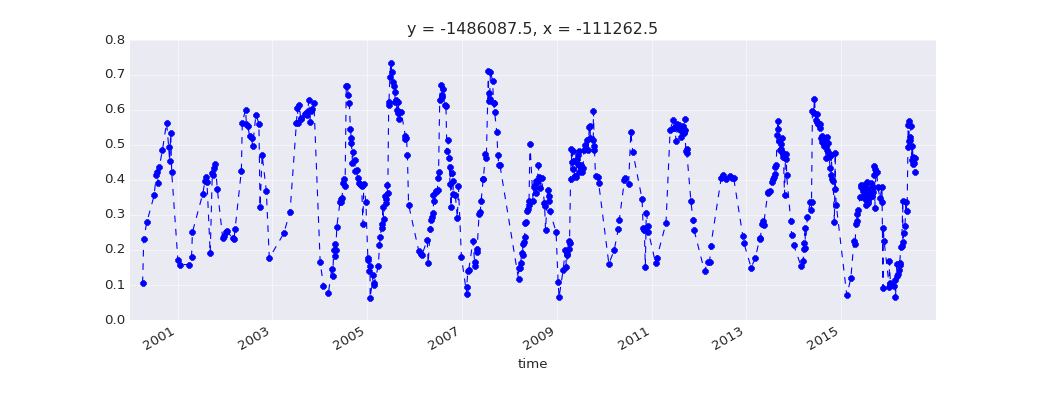

In [72]:
#Use this plot to visualise NBR time series
fig = plt.figure(figsize=(13,5))
firstyear = '2000-01-01'
lastyear = '2016-12-31'
#all_nbr_sorted.isel(x=[x],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
#all_nbr_sorted.isel(x=[x2],y=[y2]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
dnbr = 0.7 - all_nbr_sorted.isel(x=[x2],y=[y2]).dropna('time', how = 'any')
dnbr.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
plt.axis([firstyear , lastyear ,0, 0.8])
plt.grid()
savefig('/home/554/lxl554/Desktop/NBR graphics/fishriver_deltaNBR_time_series.png')

<IPython.core.display.Javascript object>


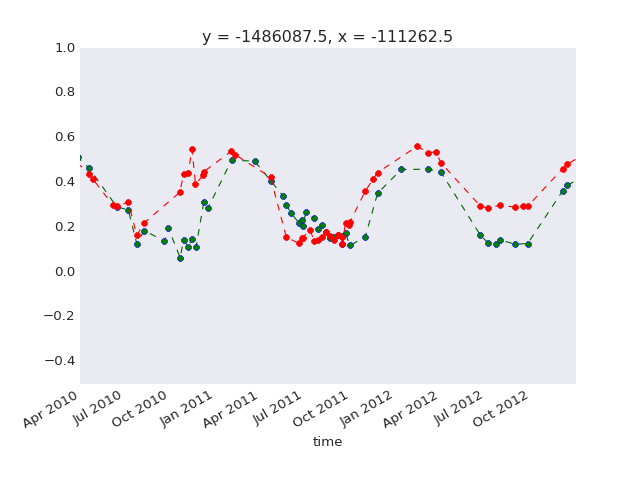

['2010-04-01', '2012-12-31', -0.5, 1]

In [64]:
#Use this plot to visualise TSS time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure()


fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

firstyear = '2010-04-01'
lastyear = '2012-12-31'
all_nbr_sorted.isel(x=[x],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'darkgreen', marker = '8', mec = 'b', mfc ='g')
all_nbr_sorted.isel(x=[x2],y=[y2]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'r', mfc ='r')
plt.axis([firstyear , lastyear ,-0.5, 1])

In [66]:
ts = all_nbr_sorted.isel(x=[x2],y=[y2]).dropna('time', how = 'any')
dnbr = 0.7 - ts

<IPython.core.display.Javascript object>


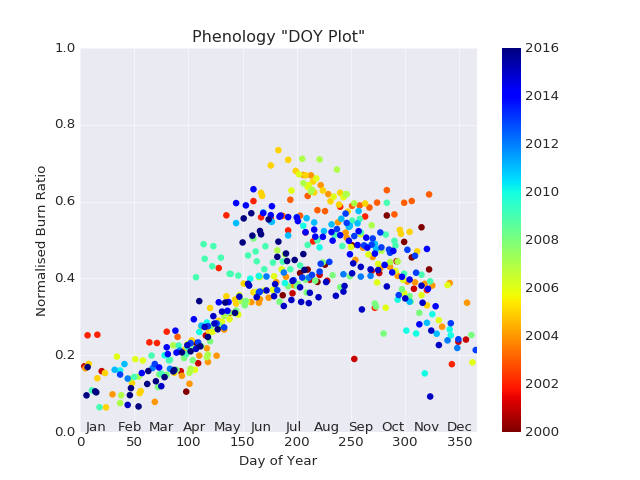

In [67]:

#This is the phenology stacking code from Chris Holden - Boston University
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = dnbr

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet_r, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('Normalised Burn Ratio')
ax.set_title('Phenology "DOY Plot"')
savefig('/home/554/lxl554/Desktop/NBR graphics/fishriver_deltaNBR_phenology3.png')

In [73]:
annual_nbr = all_nbr_sorted.groupby('time.year')

annual_nbrmin = annual_nbr.min(dim = 'time')
annual_nbrmax = annual_nbr.max(dim = 'time')
dnbr = annual_nbrmax - annual_nbrmin

<IPython.core.display.Javascript object>


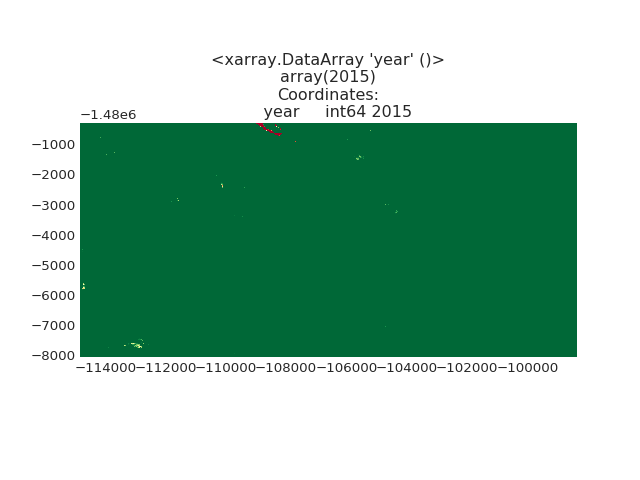

In [232]:
fig = plt.figure()
i = 15
plt.title(dnbr.year[i])
vmin = 0.85
vmax = 1
plt.imshow(dnbr[i], interpolation = 'nearest', cmap = 'RdYlGn_r', vmin = vmin, vmax = vmax, 
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
#savefig('/home/554/lxl554/Desktop/NBR graphics/fishriver_deltaNBR_2009.png')

<IPython.core.display.Javascript object>


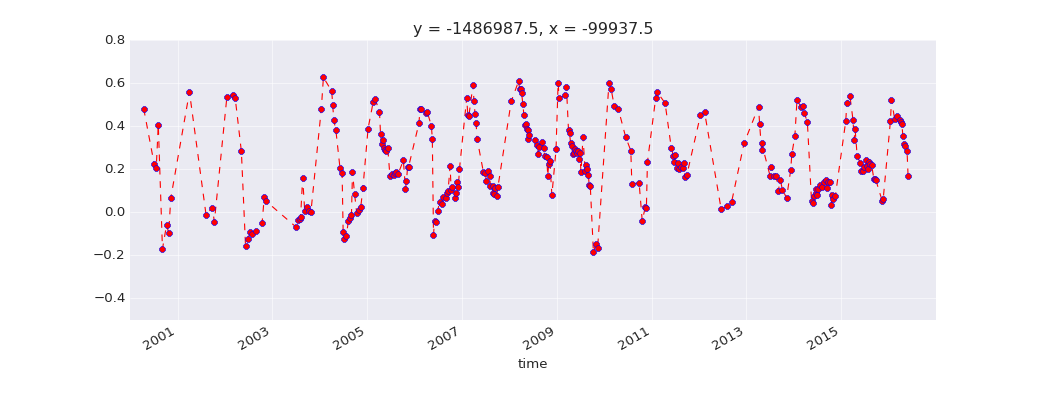

In [120]:
#Use this plot to visualise NBR time series
fig = plt.figure(figsize=(13,5))
firstyear = '2000-01-01'
lastyear = '2016-12-31'
all_nbr_sorted.isel(x=[imagex],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
#all_nbr_sorted.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
plt.axis([firstyear , lastyear ,-0.5, 0.8])
plt.grid()